In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d idhamozi/indonesian-sign-language-bisindo

 99% 885M/890M [00:09<00:00, 54.9MB/s]
100% 890M/890M [00:10<00:00, 93.2MB/s]


In [ ]:
import zipfile 
zip_file = zipfile.ZipFile('/content/indonesian-sign-language-bisindo.zip')
zip_file.extractall('/tmp/')

In [ ]:
import tensorflow as tf

print(len(tf.config.list_physical_devices('GPU')))

1


In [ ]:
#Set Parameter
batch_size = 32     # set ukuran size
img_height = 224    # untuk set panjang image
img_width = 224    # untuk set panjang image

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

# Create a list with the filepaths for training and testing
train_dir = Path('/tmp/Dataset BISINDO/datatrain')

test_dir = Path('/tmp/Dataset BISINDO/datatest')


# Get the filepaths and labels for the training data
train_filepaths = list(train_dir.glob(r'**/*.JPG'))
train_labels = [path.parent.name for path in train_filepaths]

# Get the filepaths and labels for the test data
test_filepaths = list(test_dir.glob(r'**/*.JPG'))
test_labels = [path.parent.name for path in test_filepaths]

# Create a DataFrame
df_train = pd.DataFrame({'Filepath': train_filepaths, 'Label': train_labels})
df_test = pd.DataFrame({'Filepath': test_filepaths, 'Label': test_labels})

print("Number of images in df_train:", len(df_train))
print("Number of labels in df_train:", len(df_train['Label'].unique()))
print("Number of images in df_test:", len(df_test))
print("Number of labels in df_test:", len(df_test['Label'].unique()))
print("Classes in df_train:", df_train['Label'].unique())
print("Classes in df_test:", df_test['Label'].unique())

Number of images in df_train: 1727
Number of labels in df_train: 27
Number of images in df_test: 432
Number of labels in df_test: 27
Classes in df_train: ['I' 'B' 'Y' 'R' 'J' 'O' 'K' 'E' 'NOTHING' 'C' 'X' 'W' 'H' 'M' 'N' 'S' 'L'
 'A' 'V' 'F' 'U' 'P' 'D' 'Q' 'Z' 'T' 'G']
Classes in df_test: ['I' 'B' 'Y' 'R' 'J' 'O' 'K' 'E' 'NOTHING' 'C' 'X' 'W' 'H' 'M' 'N' 'S' 'L'
 'A' 'V' 'F' 'U' 'P' 'D' 'Q' 'Z' 'T' 'G']


In [ ]:
df_train.head(10)

,Filepath,Label
0,/tmp/Dataset BISINDO/datatrain/I/IMG_9732.JPG,I
1,/tmp/Dataset BISINDO/datatrain/I/IMG_9683.JPG,I
2,/tmp/Dataset BISINDO/datatrain/I/IMG_9684.JPG,I
3,/tmp/Dataset BISINDO/datatrain/I/IMG_9679.JPG,I
4,/tmp/Dataset BISINDO/datatrain/I/IMG_2027.JPG,I
5,/tmp/Dataset BISINDO/datatrain/I/IMG_9716.JPG,I
6,/tmp/Dataset BISINDO/datatrain/I/IMG_9693.JPG,I
7,/tmp/Dataset BISINDO/datatrain/I/IMG_9721.JPG,I
8,/tmp/Dataset BISINDO/datatrain/I/IMG_9711.JPG,I
9,/tmp/Dataset BISINDO/datatrain/I/IMG_2031.JPG,I


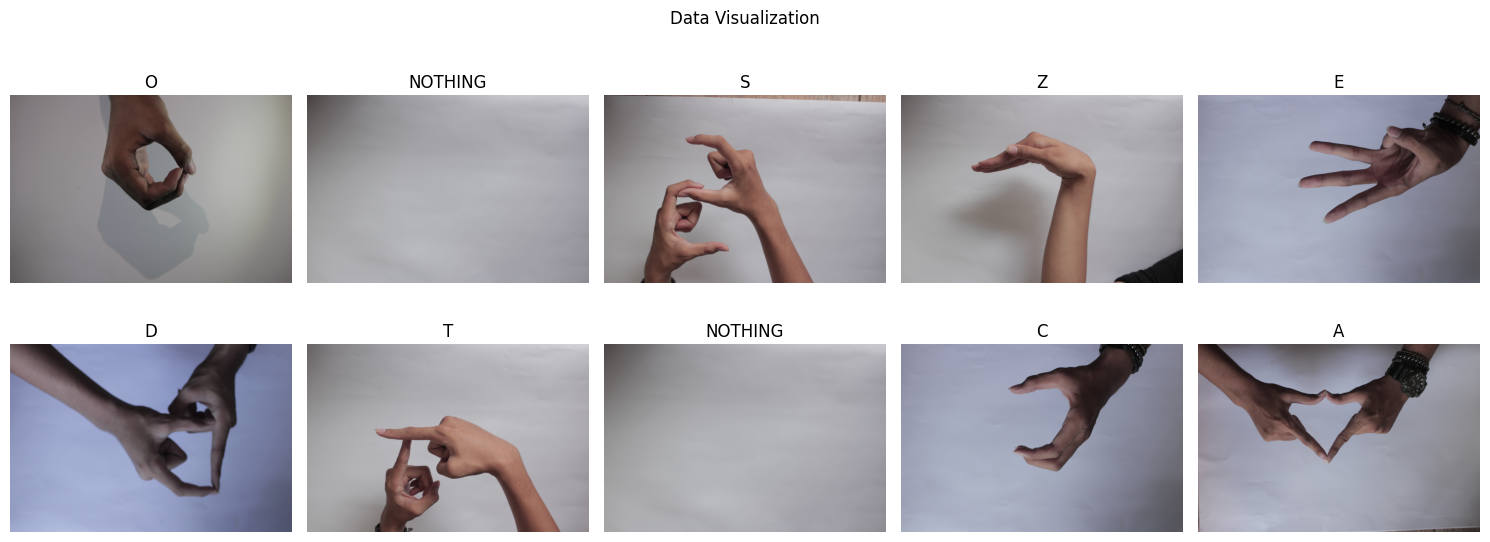

In [ ]:
# Create a figure with subplots for visualization
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Data Visualization')

# Iterate over the train dataset and plot the images with labels
for i, (_, row) in enumerate(df_train.sample(5).iterrows()):
    image_path = row['Filepath']
    label = row['Label']
    image = plt.imread(str(image_path))
    axs[0, i].imshow(image)
    axs[0, i].set_title(label)
    axs[0, i].axis('off')

# Iterate over the test dataset and plot the images with labels
for i, (_, row) in enumerate(df_test.sample(5).iterrows()):
    image_path = row['Filepath']
    label = row['Label']
    image = plt.imread(str(image_path))
    axs[1, i].imshow(image)
    axs[1, i].set_title(label)
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the input shape
input_shape = (img_height, img_width, 3)  # Assuming RGB images

# Create a sequential model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output from the previous layer
model.add(Flatten())

# Add dropout layer
model.add(Dropout(0.2))

# Add dense layers
model.add(Dense(1024, activation='relu'))
model.add(Dense(27, activation='softmax'))


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image data generator parameters for augmentation or preprocessing
train_generator = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

train_datagen = train_generator.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

test_generator = ImageDataGenerator(rescale=1/255)

val_datagen = test_generator.flow_from_directory(test_dir,
                                                 target_size=(img_height, img_width),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')



Found 1727 images belonging to 27 classes.
Found 432 images belonging to 27 classes.


In [ ]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps = 20, decay_rate = 0.98, staircase = True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience = 10, restore_best_weights = True
)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate = lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

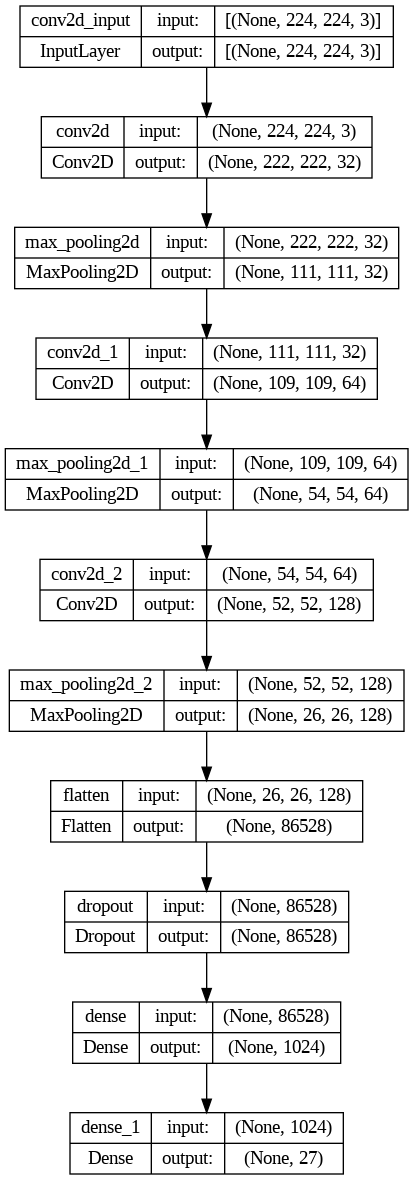

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='model60.png', show_shapes=True)

In [ ]:
# Melatih model
history = model.fit(
    train_datagen,
    steps_per_epoch=54,
    epochs=100,
    validation_data=val_datagen,
    validation_steps= 14,
    verbose=2,
    callbacks=early_stopping_cb
)

Epoch 1/100
54/54 - 153s - loss: 3.2157 - accuracy: 0.0724 - val_loss: 3.0192 - val_accuracy: 0.1366 - 153s/epoch - 3s/step
Epoch 2/100
54/54 - 138s - loss: 2.8809 - accuracy: 0.1610 - val_loss: 2.6644 - val_accuracy: 0.2037 - 138s/epoch - 3s/step
Epoch 3/100
54/54 - 138s - loss: 2.5026 - accuracy: 0.2635 - val_loss: 2.1915 - val_accuracy: 0.3472 - 138s/epoch - 3s/step
Epoch 4/100
54/54 - 141s - loss: 2.1632 - accuracy: 0.3434 - val_loss: 1.9575 - val_accuracy: 0.4005 - 141s/epoch - 3s/step
Epoch 5/100
54/54 - 136s - loss: 2.0864 - accuracy: 0.3347 - val_loss: 1.9276 - val_accuracy: 0.3657 - 136s/epoch - 3s/step
Epoch 6/100
54/54 - 138s - loss: 1.9449 - accuracy: 0.3741 - val_loss: 1.6716 - val_accuracy: 0.4329 - 138s/epoch - 3s/step
Epoch 7/100
54/54 - 157s - loss: 1.7803 - accuracy: 0.4314 - val_loss: 1.6419 - val_accuracy: 0.4630 - 157s/epoch - 3s/step
Epoch 8/100
54/54 - 136s - loss: 1.7697 - accuracy: 0.4117 - val_loss: 1.4432 - val_accuracy: 0.5532 - 136s/epoch - 3s/step
Epoch 9/

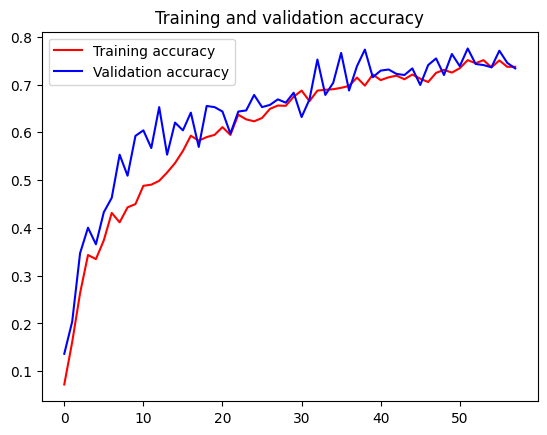

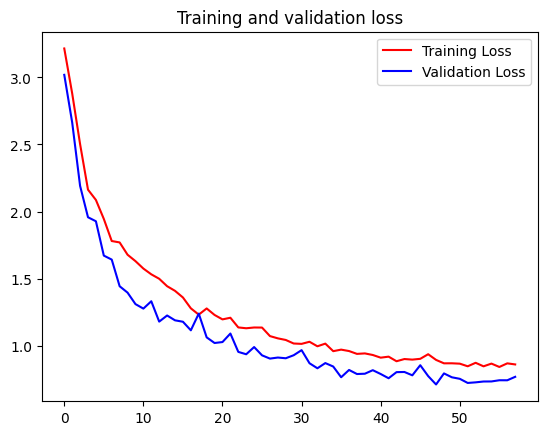

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Specify the path to save the model
model_path = "my_model_fix/model.h5"

# Save the model
model.save(model_path)

# Print a message to confirm the save
print("Model saved at:", model_path)

Model saved at: my_model/model.h5


In [ ]:
# Predict the label of the test_images
pred = model.predict(val_datagen)
pred = np.argmax(pred,axis=1)

# Map the label
labels =  train_datagen.class_indices
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in val_datagen.classes]

14/14 [==============================] - 29s 2s/step
